# Inverse Design of a Waveguide Bend

In this example, we will walk you through performing a simple inverse design optimization of a 3D waveguide bend.

In this example, we'll be using a pixelated material grid to define the design region. However, one could also use shape parameterization to do the same problem. If you're interested in that, we have a demo available [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd8WaveguideBend/).

<!-- 
<img src="img/adjoint_9.png" width=400 alt="Schematic of the waveguide division multiplexer"> -->

<!-- EMERSON / TOM : insert info about signing up -->

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

> Note: to see to the simple, [high level definition](https://www.flexcompute.com/tidy3d/examples/notebooks/InverseDesign/) of the inverse desgin problem using `tidy3d.plugins.invdes`, jump to the 2nd to last cell!

Before using Tidy3D, you must first [sign up](https://tidy3d.simulation.cloud/signup) for a user account. See [this link](https://docs.flexcompute.com/projects/tidy3d/en/latest/install.html) for installation instructions.


## Setup

First we import the packages we need and also define some of the global parameters that define our problem.

> Important note: we use `autograd.numpy` instead of regular `numpy`, this allows `numpy` functions to be differentiable. If one forgets this step, the error may be a bit opaque, just a heads up.

In [1]:
import tidy3d as td
import tidy3d.web as web

import matplotlib.pylab as plt
import autograd
import autograd.numpy as np

In [2]:
# spectral parameters
wvl0 = 1.0
freq0 = td.C_0 / wvl0

# geometric parameters
eps_mat = 4.0
wg_width = 0.5 * wvl0
wg_length = 1.0 * wvl0
design_size = 3 * wvl0
thick = 0.2 * wvl0

# effective feature size for device (um)
radius = 0.150

# resolution
pixel_size = wvl0/50
min_steps_per_wvl = wvl0 / (pixel_size * np.sqrt(eps_mat))

Next, we will define all the components that make up our "base" simulation. This simulation defines the static portion of our optimization, which doesn't change over the iterations.

For now, we'll include a definition of the design region geometry, just to have that on hand later, but will not include a design region in the base simulation as we'll add it later.

In [3]:
waveguide_in = td.Structure(
    geometry=td.Box(
        center=(-wg_length-design_size/2, 0, 0),
        size=(2 * wg_length, wg_width, thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

waveguide_out = td.Structure(
    geometry=td.Box(
        center=(0, waveguide_in.geometry.center[0], 0),
        size=(wg_width, waveguide_in.geometry.size[0], thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

design_region_geometry = td.Box(
    center=(0,0,0),
    size=(design_size, design_size, thick),
)

mode_source = td.ModeSource(
    center=(-design_size/2.0-wg_length+wvl0/3, 0, 0),
    size=(0, wg_width * 3, td.inf),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=freq0/20,
    ),
    mode_index=0,
    direction="+"
)

mode_monitor = td.ModeMonitor(
    center=(0, mode_source.center[0], 0),
    size=(mode_source.size[1], 0, td.inf),
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=1),
    name='mode',
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field',
)

sim_base = td.Simulation(
    size=(2 * wg_length + design_size, 2 * wg_length + design_size, thick + 2 * wvl0),
    run_time=100/mode_source.source_time.fwidth,
    structures=[waveguide_in, waveguide_out],
    sources=[mode_source],
    monitors=[mode_monitor],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[
            td.MeshOverrideStructure(
                geometry=design_region_geometry,
                dl=3*[pixel_size]
            )
        ]
    )
)

Let's vizualize the base simulation to verify that it looks correct.

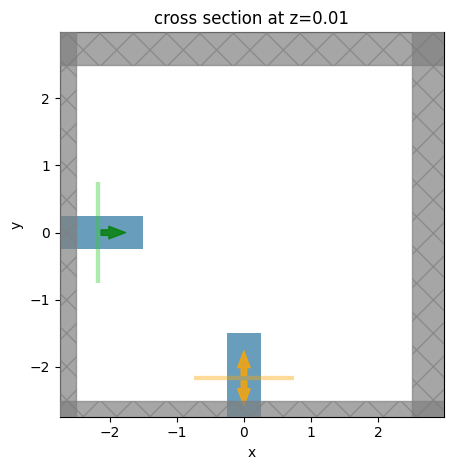

In [4]:
ax = sim_base.plot(z=0.01)
plt.show()

## Define Parameterization

Next, we will define how our design region is constructed as a function of our optimization parameters.

We will define a structure containing a grid of permittivity values defined by an array. We will convolve our optimization parameters with a conic filter to smooth the features over a given `radius`. Then we will add a pixel-by-pixel thresholding function to project the values to be more binarized. We'll then map the result to the permittivity range between air and that of the waveguide.

For more details on the parameterization process, we highly recommend [our short tutorial](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/Inverse-Design-in-Photonics-Lecture-4-Fabrication-Constraints/), which explains the process in more detail.

The filter and projection functions are included in our `tidy3d.plugins.autograd` plugin, which contains many other useful convenience tools. We'll import a single transformation function from there to avoid needing to implement it.

We'll expose the projection strength `beta` as a free parameter so we can change it during the course of optimization.

In [5]:
from tidy3d.plugins.autograd import make_filter_and_project

filter_project_fn = make_filter_and_project(radius=radius, dl=pixel_size)

def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of the material in the design region as function of optimization parameters."""
    return filter_project_fn(params, beta=beta)

def get_design_region(params: np.ndarray, beta: float) -> td.Structure:
    """Get design region structure as a function of optimization parameters."""
    density = get_density(params, beta=beta)
    eps_data = 1 + (eps_mat - 1) * density
    return td.Structure.from_permittivity_array(
        eps_data=eps_data,
        geometry=design_region_geometry
    )

Next, it is very convenient to wrap this in a function that returns an updated copy of the base simulation with the design region added. We'll be calling this in our objective function. We'll also add some logic to exlude field monitors if they aren't needed, for example during the optimization.

In [6]:
def get_sim(params: np.ndarray, beta: float, with_fld_mnt: bool=False) -> td.Simulation:
    """Get simulation as a function of optimization parameters."""
    design_region = get_design_region(params, beta=beta)
    sim = sim_base.updated_copy(structures=sim_base.structures + (design_region,))
    if with_fld_mnt:
        sim = sim.updated_copy(monitors=sim_base.monitors + (field_monitor,))
    return sim

Next, let's create a set of initial parameters (initially uniform with halfway values of 0.5) and see what the initial simulation looks like!

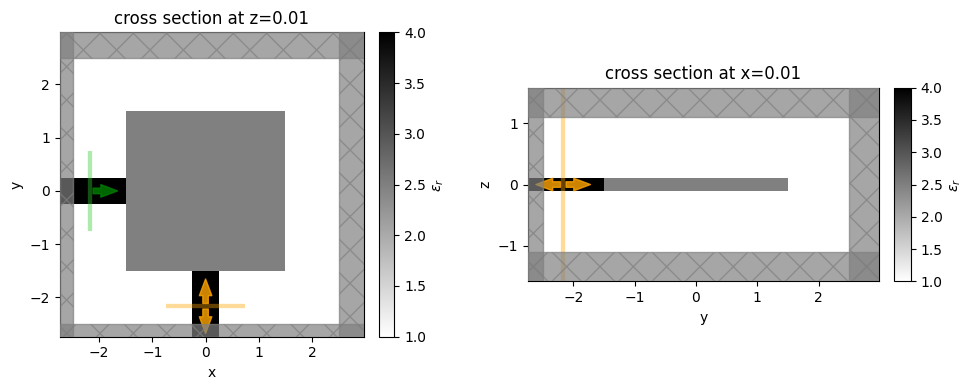

In [7]:
num_pixels_dim = int(design_size / pixel_size)

params0 = np.ones((num_pixels_dim, num_pixels_dim, 1)) * 0.5
# params0 = np.random.random((num_pixels_dim, num_pixels_dim, 1)) # if you want random, uncomment
sim0 = get_sim(params0, beta=50.0)

_, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10,4))
sim0.plot_eps(z=0.01, ax=ax1)
sim0.plot_eps(x=0.01, ax=ax2)
plt.show()

We can also run a quick simulation with a field monitor added to verify how poorly the initial device is coupling. This gives us lots of room to improve things through optimization!

In [8]:
sim_data_init = web.run(sim0.updated_copy(monitors=[field_monitor]), task_name="initial_bend")

17:05:49 EDT Created task 'initial_bend' with task_id                           
             'fdve-2af33e49-38f6-4599-a253-c1c13ae51c11' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=66877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=55429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\taskId]8;;\]8;id=66877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\=]8;;\]8;id=887716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\fdve]8;;\]8;id=66877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\-2af33e49-38f]8;;\
             ]8;id=66877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2af33e49-38f6-4599-a253-c1c13ae51c11\6-4599-a253-c1c13ae51c11']8;;\.

Output()

17:05:51 EDT status = success

Output()

17:05:54 EDT loading simulation from simulation_data.hdf5

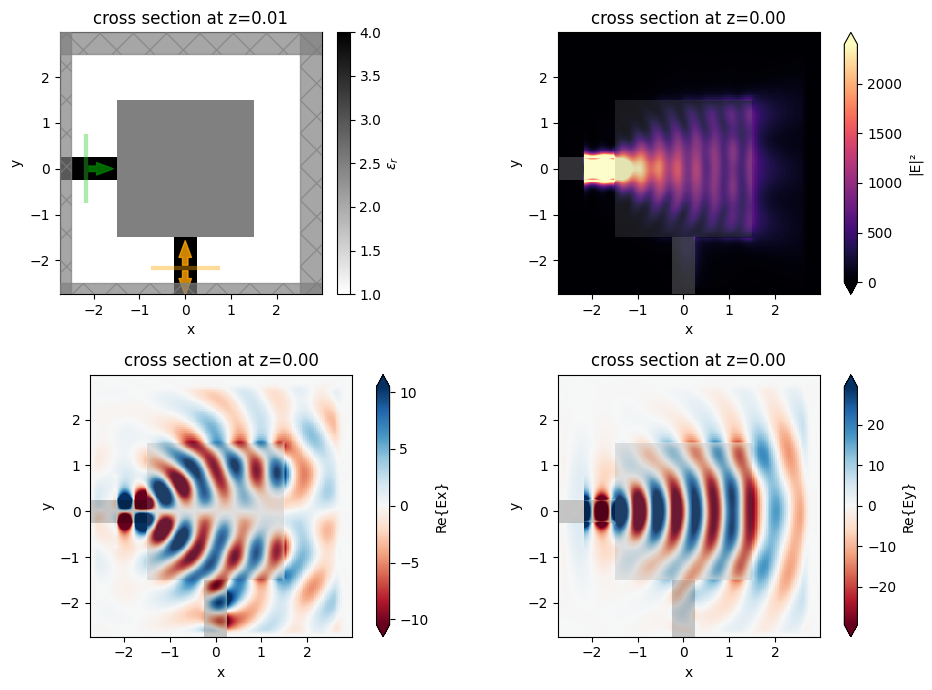

In [9]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim0.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_init.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_init.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_init.plot_field("field", "Ey", z=0, ax=ax3)

## Define Objective Function

The next step is to define the metric that we want to optimize, or our "figure of merit". We will first write a function to compute the transmission (between 0-1) of the output mode given the simulation data. 

We'll also use the `tidy3d.plugins.autograd` tools to create a penalty for feature sizes smaller than our `radius` parameter defined earlier.

In [10]:
from tidy3d.plugins.autograd import make_erosion_dilation_penalty

def get_transmission(params: np.ndarray, beta: float) -> float:
    """Get transmission in output waveguide fundamental mode."""
    sim = get_sim(params, beta=beta)
    data = web.run(sim, task_name='bend', verbose=False)
    mode_amps = data['mode'].amps.sel(direction='-').values
    return np.sum(np.abs(mode_amps)**2)

penalty_fn = make_erosion_dilation_penalty(radius=radius, dl=pixel_size, beta=10.0)

def get_penalty(params: np.ndarray, beta: float) -> float:
    """Get penalty due to violation of fabrication constraints."""
    density = get_density(params, beta=beta)
    return penalty_fn(density)

Next we can put everything together into a single objective function. We'll add a flag that ignores the simulation run, if we want to just test our parameterization quickly without running FDTD.

In [11]:
def objective(params: np.ndarray, beta: float, only_penalty:bool=False) -> float:
    """Objective function."""
    penalty = get_penalty(params, beta=beta)    

    if only_penalty:
        return -penalty

    transmission = get_transmission(params, beta=beta)
    return transmission - penalty

## Optimization

Getting the gradient of the `objective` function is easy using `autograd`. Calling `g = autograd.value_and_grad(f)` returns a function `g` that when evaluated returns the objetive function value and its gradient.

We use this as it's more efficient and we dont have to re-compute the objective during the gradient calculation step if we want to store the value too.

Let's construct this function now and have it ready to use in the main optimization loop.

In [12]:
val_grad_fn = autograd.value_and_grad(objective)

Next we will run the optimizer, we first make a cell to define the parameters and some convenience functions and objects to store our history.

In [13]:
import optax

# hyperparameters
num_steps = 25
learning_rate = 1

# initialize adam optimizer with starting parameters
params = 0.5 * np.ones_like(params0)
# params = np.random.random(params0.shape) # uncomment to use random initial parameters, if you're feeling lucky

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# beta as a function of step number, ramping it up leads to better results generally
beta_min = 5
beta_max = 20
def get_beta(step_num: int) -> float:
    """projection strength as a function of step number."""
    return beta_min + (beta_max - beta_min) * step_num / (num_steps - 1)

# store history
objective_history = []
param_history = [params]

And then we can iteratively update our optimizer and parameters using the gradient calculated in each step.

We'll throw in a quick visualization of our device material density just to keep an eye on things as the optimization progresses.

> Note: the following optimization loop will take about half an hour. To run fewer iterations, just change `num_steps` to something smaller above.

step = 1
beta = 5.00


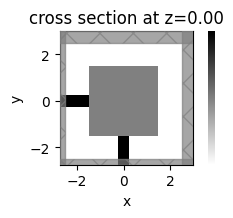

	J = -9.8747e-01
	grad_norm = 6.8133e-01
step = 2
beta = 5.62


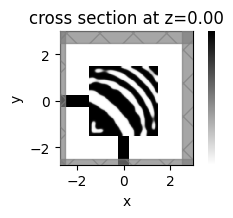

	J = -1.9800e-01
	grad_norm = 5.1710e-01
step = 3
beta = 6.25


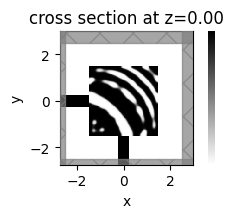

	J = -8.3703e-02
	grad_norm = 1.0602e+00
step = 4
beta = 6.88


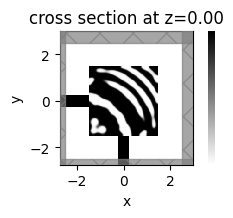

	J = 3.7340e-02
	grad_norm = 1.0330e+00
step = 5
beta = 7.50


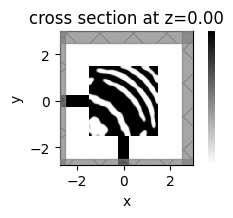

	J = 2.6498e-01
	grad_norm = 7.6807e-01
step = 6
beta = 8.12


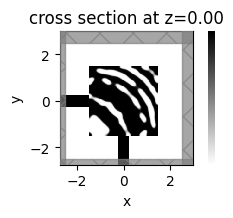

	J = 1.4501e-01
	grad_norm = 3.1176e+00
step = 7
beta = 8.75


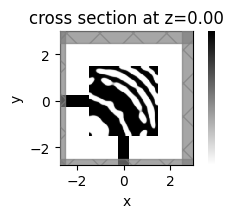

	J = 2.7809e-01
	grad_norm = 1.3119e+00
step = 8
beta = 9.38


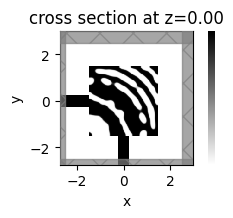

	J = 3.8745e-01
	grad_norm = 1.2009e+00
step = 9
beta = 10.00


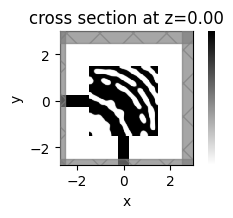

	J = 4.9170e-01
	grad_norm = 7.9113e-01
step = 10
beta = 10.62


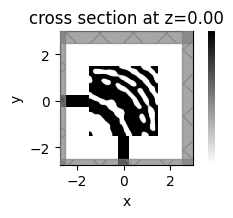

	J = 5.2233e-01
	grad_norm = 6.9752e-01
step = 11
beta = 11.25


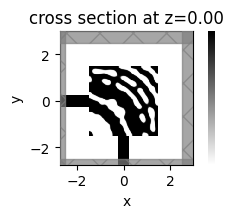

	J = 5.5150e-01
	grad_norm = 4.8258e-01
step = 12
beta = 11.88


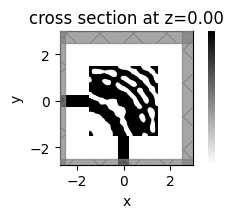

	J = 5.6870e-01
	grad_norm = 5.2501e-01
step = 13
beta = 12.50


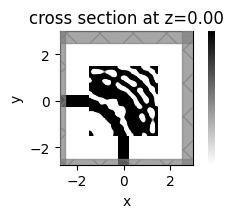

	J = 5.8872e-01
	grad_norm = 4.5345e-01
step = 14
beta = 13.12


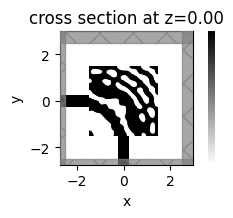

	J = 6.0137e-01
	grad_norm = 3.6628e-01
step = 15
beta = 13.75


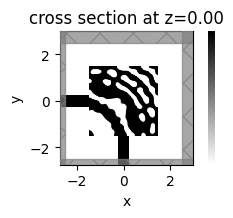

	J = 5.9710e-01
	grad_norm = 4.9288e-01
step = 16
beta = 14.38


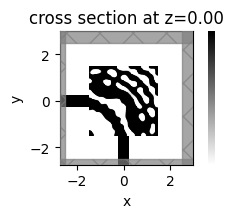

	J = 5.8032e-01
	grad_norm = 1.5782e+00
step = 17
beta = 15.00


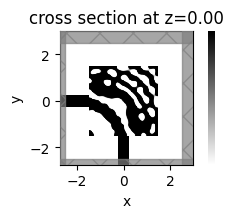

	J = 5.5875e-01
	grad_norm = 1.1480e+00
step = 18
beta = 15.62


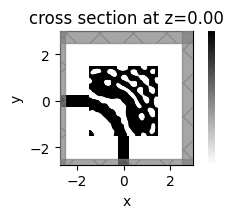

	J = 6.1763e-01
	grad_norm = 4.7004e-01
step = 19
beta = 16.25


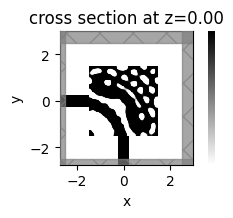

	J = 6.1152e-01
	grad_norm = 1.4769e+00
step = 20
beta = 16.88


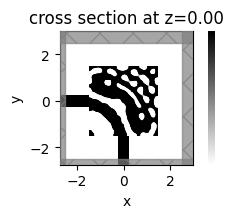

	J = 6.2107e-01
	grad_norm = 7.8201e-01
step = 21
beta = 17.50


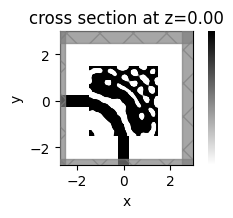

	J = 6.2295e-01
	grad_norm = 6.5727e-01
step = 22
beta = 18.12


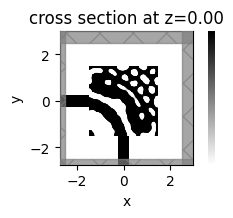

	J = 6.5138e-01
	grad_norm = 3.9320e-01
step = 23
beta = 18.75


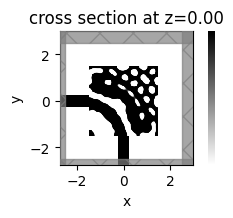

	J = 6.5978e-01
	grad_norm = 7.2811e-01
step = 24
beta = 19.38


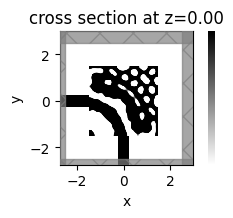

	J = 6.5951e-01
	grad_norm = 3.4906e-01
step = 25
beta = 20.00


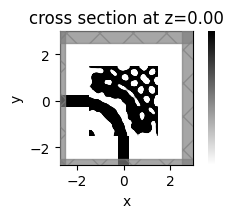

	J = 6.4354e-01
	grad_norm = 1.0729e+00
CPU times: user 40.4 s, sys: 4.04 s, total: 44.5 s
Wall time: 6min 45s


In [14]:
%%time
for i in range(num_steps):

    print(f"step = {i + 1}")

    beta = get_beta(i)
    print(f"beta = {beta:.2f}")

    sim_i = get_sim(params, beta=beta)
    _, ax = plt.subplots(figsize=(2,2))
    sim_i.plot_eps(z=0, ax=ax, monitor_alpha=0.0, source_alpha=0.0)
    plt.axis('off')
    plt.show()
    
    # re-compute gradient and current objective funciton value
    value, gradient = val_grad_fn(params, beta=beta)

    # outputs
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the parameters using the gradient (-1 sign to maximize)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # it is important (when using optax) to convert the parameters back to numpy arrays to feed back to our gradient
    params = np.array(params)

    # we also need to constrain the values between (0,1)
    params = np.clip(params, 0, 1)

    # save history
    objective_history.append(value)
    param_history.append(params)

## Analysis

Now is the fun part! We get to take a look at our optimization results.

We first plot the objective function values over the course of optimization, which should show a steady increase and leveling off, indicating that we've found a maximum.

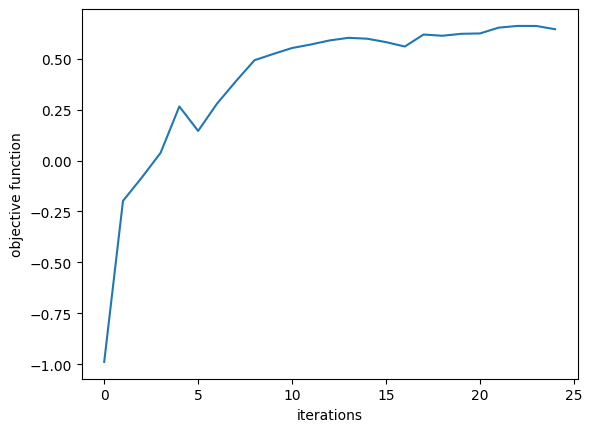

In [15]:
plt.plot(objective_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

Next, we can look at the performance of our optimized device, we first construct it using the final parameter values and then take a look at the design.

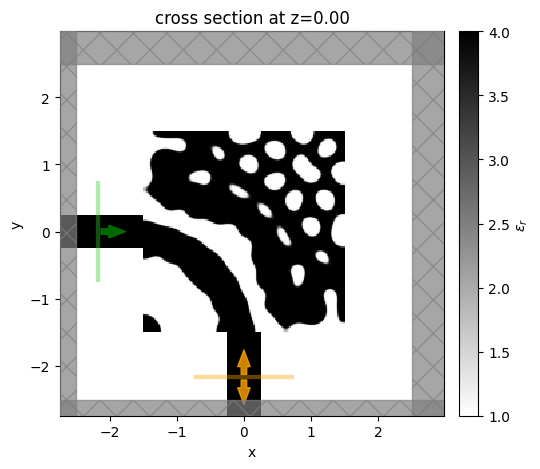

In [16]:
params_final = param_history[-1]
sim_final = get_sim(params_final, beta=beta)
sim_final.plot_eps(z=0)
plt.show()

It seems to exhibit large feature sizes, which is promising! There are some discontinuities with the waveguide, which could be rectified with a more advanced approach, but is beyond the scope of this notebook.

Let's add a multi-frequency mode monitor and a field monitor to inpsect the performance.

In [17]:
mode_monitor_final = mode_monitor.updated_copy(freqs=td.C_0 / np.linspace(wvl0 * 1.2, wvl0 / 1.2, 101))
sim_final = sim_final.updated_copy(monitors=(field_monitor, mode_monitor_final))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

17:12:42 EDT Created task 'inv_des_final' with task_id                          
             'fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=841039;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=140800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\taskId]8;;\]8;id=841039;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\=]8;;\]8;id=602737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\fdve]8;;\]8;id=841039;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\-884a3ead-8ae]8;;\
             ]8;id=841039;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\0-4542-8cb8-d67fd1c35b49']8;;\.

Output()

17:12:45 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:12:50 EDT status = preprocess

17:12:52 EDT Maximum FlexCredit cost: 0.328. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

17:13:13 EDT early shutoff detected at 4%, exiting.

             status = postprocess

Output()

17:13:17 EDT status = success

             View simulation result at                                          
             ]8;id=611766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=454618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\taskId]8;;\]8;id=611766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\=]8;;\]8;id=491961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\fdve]8;;\]8;id=611766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\-884a3ead-8ae]8;;\
             ]8;id=611766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-884a3ead-8ae0-4542-8cb8-d67fd1c35b49\0-4542-8cb8-d67fd1c35b49']8;;\.

Output()

17:13:19 EDT loading simulation from simulation_data.hdf5

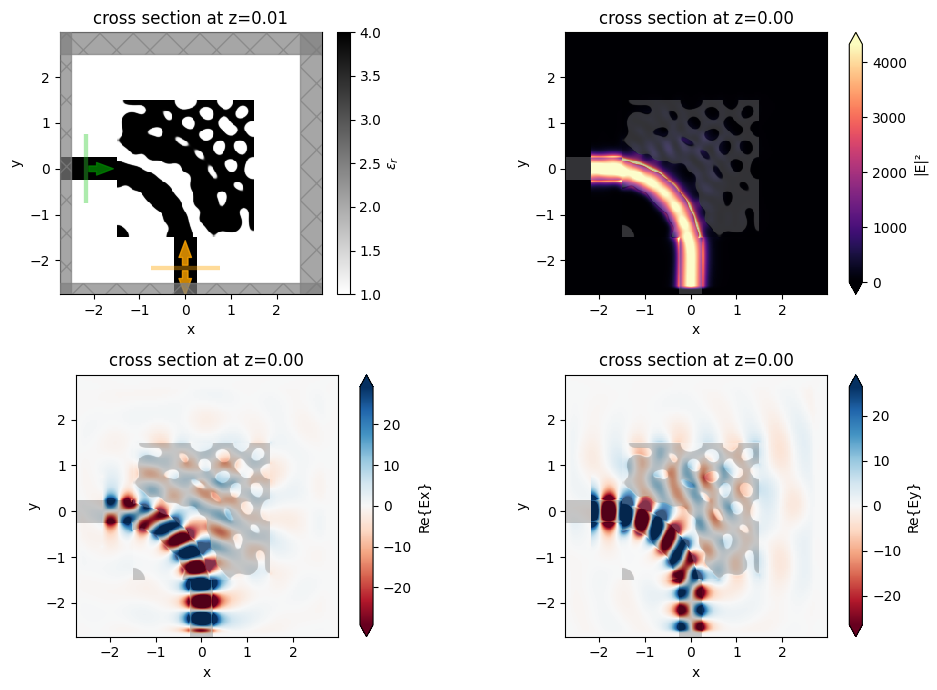

In [18]:
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim_final.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_final.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_final.plot_field("field", "Ey", z=0, ax=ax3)
plt.show()

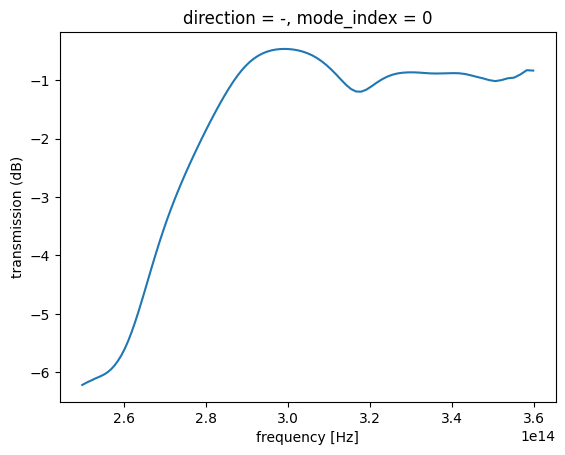

In [19]:
transmission = abs(sim_data_final['mode'].amps.sel(direction='-'))**2
transmission_db = 10 * np.log10(transmission)
transmission_db.plot(x='f')
plt.ylabel('transmission (dB)')
plt.show()

It seems to perform quite well! Let's export the simulation to a GDS file for fabrication!

In [20]:
# uncomment below to export

# sim_final.to_gds_file(
#     fname="./misc/invdes_bend.gds",
#     z=0,
#     frequency=freq0,
#     permittivity_threshold=(eps_mat + 1) / 2.0
# )

## Using Inverse Design Plugin

The code above showed the fully flexible, function approach to performing inverse design, but we also provide and alternative, higher-level syntax for defining these sorts of problems and makes it possible with far less code. 

This is done through the Inverse Design plugin (`tidy3d.plugins.invdes`). For a full tutorial, refer to [this example](https://docs.simulation.cloud/projects/tidy3d/en/latest/notebooks/InverseDesign.html).

Below we set up the same implementation of the optimization but just in a few lines of code.

In [21]:
import tidy3d.plugins.invdes as tdi
from tidy3d.plugins.expressions import ModePower

design_region = tdi.TopologyDesignRegion(
    size=design_region_geometry.size,
    center=design_region_geometry.center,
    eps_bounds=(1.0, eps_mat),
    pixel_size=pixel_size,
    transformations=[tdi.FilterProject(radius=radius, beta=beta_max)],
    penalties=[tdi.ErosionDilationPenalty(length_scale=radius)],
    initialization_spec=tdi.CustomInitializationSpec(params=param_history[-1]) # use the final parameters to start this optimization, if left blank, will be uniform
)

design = tdi.InverseDesign(
    simulation=sim_base,
    design_region=design_region,
    task_name="invdes",
    metric=ModePower(monitor_name='mode', f=freq0, direction='-'),
)

optimizer = tdi.AdamOptimizer(
    design=design,
    num_steps=2,
    learning_rate=0.1,
)

# make True to run the optimizer for the number of steps defined above
run_optimizer = False

if run_optimizer:
    
    result = optimizer.run()
    result.plot_optimization()

## Other Examples

Here are some other selected inverse design examples if you want to explore more!

- [Mode converter](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd3InverseDesign.html)
- [Shape optimized taper](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd5BoundaryGradients.html)
- [Metalens optimization](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd7Metalens.html)
- [Wavelength division de-multiplexer](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd9WDM.html)